In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.model import VSpyct
from src.utils import (calculate_bs, fix_predictions, plot_brier)
from src.data.dataset import SurvivalDataset

/Users/viktorandonovic/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for file in os.listdir('../data/raw'):
  if '.rda' in file: print(file)

cancer.rda
logan.rda
heart.rda
survexp.rda
pbc.rda
solder.rda
tobin.rda
udca.rda
nwtco.rda
reliability.rda
cgd.rda
retinopathy.rda
transplant.rda
diabetic.rda
flchain.rda
rhDNase.rda
nafld.rda


In [26]:
import pyreadr
fname = 'heart.rda'
dataset = pyreadr.read_r(os.path.join('../data/raw', fname))[fname.split('.')[0].split('/')[-1]]
dataset

,start,stop,event,age,year,surgery,transplant,id
rownames,,,,,,,,
1,0.0,50.0,1.0,-17.155373,0.123203,0.0,0,1.0
2,0.0,6.0,1.0,3.835729,0.254620,0.0,0,2.0
3,0.0,1.0,0.0,6.297057,0.265572,0.0,0,3.0
4,1.0,16.0,1.0,6.297057,0.265572,0.0,1,3.0
5,0.0,36.0,0.0,-7.737166,0.490075,0.0,0,4.0
...,...,...,...,...,...,...,...,...
168,0.0,38.0,0.0,-12.939083,6.395619,1.0,0,100.0
169,38.0,39.0,0.0,-12.939083,6.395619,1.0,1,100.0
170,0.0,31.0,0.0,1.516769,6.417522,0.0,0,101.0


In [27]:
from tqdm import tqdm
random_states = [11,22,33,44]
tt = []
et = []
for rs in tqdm(random_states):
  data = SurvivalDataset(fname=fname, path='../data/raw/', random_state=rs)
  data.dataset['time'] = data.dataset['stop'] - data.dataset['start']
  tensor_tuple = data.get_tensors('time', 'event')
  tt.append(tensor_tuple)
  x_train, T_train, E_train, x_test, T_test, E_test = data.pysurvival_split('time', 'event')
  et.append((x_train, x_test, T_train, T_test, E_train, E_test))


  0%|          | 0/4 [00:00<?, ?it/s]

1775


172it [00:00, 254.42it/s]
 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]

Succesfully created time tensor of shape: torch.Size([172, 1775])
(137, 7) torch.Size([137, 1775])
1775


172it [00:00, 249.70it/s]
 50%|█████     | 2/4 [00:01<00:01,  1.39it/s]

Succesfully created time tensor of shape: torch.Size([172, 1775])
(137, 7) torch.Size([137, 1775])
1775


172it [00:00, 262.78it/s]
 75%|███████▌  | 3/4 [00:02<00:00,  1.44it/s]

Succesfully created time tensor of shape: torch.Size([172, 1775])
(137, 7) torch.Size([137, 1775])
1775


172it [00:00, 261.22it/s]
100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

Succesfully created time tensor of shape: torch.Size([172, 1775])
(137, 7) torch.Size([137, 1775])


In [28]:
from src.eval import IPCWBrier

bs_vspyct = []
for i, tensor_tuple in enumerate(tt):
  X_train, X_test, y_train, y_test = tt[i]
  T_test = et[i][3]
  E_test = et[i][5]
  model = VSpyct(max_depth=3, bs=64)
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  avg_preds = preds.mean(axis=1)
  _bs_ = IPCWBrier(T_test, E_test)
  bs_values = _bs_.evaluate(y_test, avg_preds)
  bs_vspyct.append(bs_values)


Total variance: 188.36607360839844
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|▏         | 7/500 [00:01<01:17,  6.36it/s]


Early stopping at epoch 7.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([100]) Var left tensor(134.1754)
Rows right:  torch.Size([37]) Var right tensor(282.3151)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|▏         | 7/500 [00:00<00:09, 54.19it/s]


Early stopping at epoch 7.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([12]) Var left tensor(14.7766)
Rows right:  torch.Size([25]) Var right tensor(319.3350)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 12/500 [00:00<00:07, 63.53it/s]

Early stopping at epoch 12.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Rows left:  torch.Size([23]) Var left tensor(331.5423)
Rows right:  torch.Size([2]) Var right tensor(6.)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 4/500 [00:00<00:05, 83.43it/s]

Early stopping at epoch 4.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([10]) Var left tensor(12.8869)
Rows right:  torch.Size([2]) Var right tensor(nan)


Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 11/500 [00:00<00:17, 28.38it/s]


Early stopping at epoch 11.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([63]) Var left tensor(53.3562)
Rows right:  torch.Size([37]) Var right tensor(196.0377)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 4/500 [00:00<00:09, 50.88it/s]


Early stopping at epoch 4.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([9]) Var left tensor(60.5000)
Rows right:  torch.Size([28]) Var right tensor(205.1537)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 4/500 [00:00<00:15, 31.90it/s]

Early stopping at epoch 4.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([1]) Var left tensor(nan)
Rows right:  torch.Size([62]) Var right tensor(53.2887)


Total variance: 177.88246154785156
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|▏         | 7/500 [00:00<00:24, 20.13it/s]


Early stopping at epoch 7.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([24]) Var left tensor(262.0246)
Rows right:  torch.Size([113]) Var right tensor(100.5900)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 4/500 [00:00<00:21, 22.98it/s]


Early stopping at epoch 4.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([13]) Var left tensor(156.9365)
Rows right:  torch.Size([100]) Var right tensor(96.7564)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 12/500 [00:00<00:16, 28.72it/s]


Early stopping at epoch 12.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([70]) Var left tensor(95.3251)
Rows right:  torch.Size([30]) Var right tensor(95.8830)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 10/500 [00:00<00:05, 97.81it/s]


Early stopping at epoch 10.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([7]) Var left tensor(226.2214)
Rows right:  torch.Size([6]) Var right tensor(8.5000)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 8/500 [00:00<00:08, 60.39it/s]


Early stopping at epoch 8.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([10]) Var left tensor(292.0571)
Rows right:  torch.Size([14]) Var right tensor(nan)
Total variance: 224.63845825195312
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 6/500 [00:00<00:24, 19.79it/s]


Early stopping at epoch 6.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([68]) Var left tensor(327.5247)
Rows right:  torch.Size([69]) Var right tensor(83.9467)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 5/500 [00:00<00:15, 32.07it/s]


Early stopping at epoch 5.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([33]) Var left tensor(126.3699)
Rows right:  torch.Size([36]) Var right tensor(49.9797)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 11/500 [00:00<00:08, 59.03it/s]

Early stopping at epoch 11.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Rows left:  torch.Size([1]) Var left tensor(nan)
Rows right:  torch.Size([35]) Var right tensor(37.9959)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   3%|▎         | 15/500 [00:00<00:07, 62.22it/s]


Early stopping at epoch 15.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([22]) Var left tensor(45.5428)
Rows right:  torch.Size([11]) Var right tensor(217.8137)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 4/500 [00:00<00:16, 30.31it/s]


Early stopping at epoch 4.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([59]) Var left tensor(241.0729)
Rows right:  torch.Size([9]) Var right tensor(117.0000)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   1%|          | 5/500 [00:00<00:05, 91.18it/s]


Early stopping at epoch 5.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([8]) Var left tensor(82.5000)
Rows right:  torch.Size([1]) Var right tensor(nan)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 11/500 [00:00<00:08, 54.94it/s]


Early stopping at epoch 11.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([41]) Var left tensor(213.2184)
Rows right:  torch.Size([18]) Var right tensor(183.)
Total variance: 197.08181762695312
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 11/500 [00:00<00:22, 21.57it/s]


Early stopping at epoch 11.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([101]) Var left tensor(131.6882)
Rows right:  torch.Size([36]) Var right tensor(284.2769)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 8/500 [00:00<00:09, 51.32it/s]

Early stopping at epoch 8.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([33]) Var left tensor(284.5516)
Rows right:  torch.Size([3]) Var right tensor(nan)


Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 11/500 [00:00<00:20, 24.34it/s]


Early stopping at epoch 11.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([79]) Var left tensor(81.1196)
Rows right:  torch.Size([22]) Var right tensor(279.6854)
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 10/500 [00:00<00:07, 63.00it/s]

Early stopping at epoch 10.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([9]) Var left tensor(29.0536)
Rows right:  torch.Size([13]) Var right tensor(431.7862)


Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)


Epochs:   2%|▏         | 9/500 [00:00<00:14, 32.95it/s]


Early stopping at epoch 9.
Impurity(
  (linear): PyroLinear(in_features=7, out_features=1, bias=True)
)
Rows left:  torch.Size([77]) Var left tensor(83.4346)
Rows right:  torch.Size([2]) Var right tensor(8.5000)


In [29]:
bs_vspyct_arr = []
for vec in bs_vspyct:
  bs_vspyct_arr.append(np.array(vec))

bs_vspyct_arr = np.array(bs_vspyct_arr)

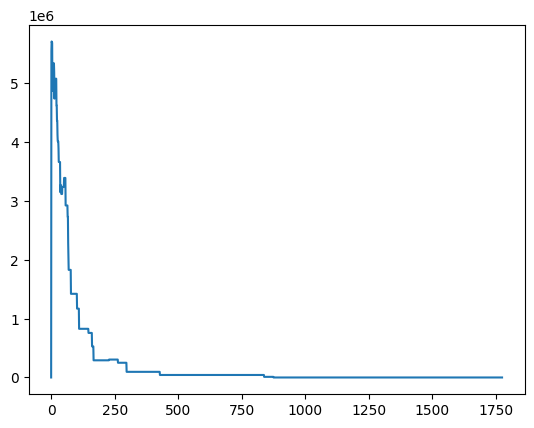

In [30]:
plt.plot(bs_vspyct_arr.mean(axis=0))

In [31]:
import spyct

bs_spyct = []
for i, tensor_tuple in enumerate(tt):
  X_train, X_test, y_train, y_test = tt[i]
  x_train = et[i][0]
  x_test = et[i][1]
  T_test = et[i][3]
  E_test = et[i][5]
  model = spyct.Model(max_depth=3)
  model.fit(x_train.values, y_train.numpy())
  preds = model.predict(x_test.values)
  _bs_ = IPCWBrier(T_test, E_test)
  bs_values = _bs_.evaluate(y_test, preds)
  bs_spyct.append(bs_values)

In [32]:
bs_spyct_arr = []
for vec in bs_spyct:
  bs_spyct_arr.append(np.array(vec))

bs_spyct_arr = np.array(bs_spyct_arr)

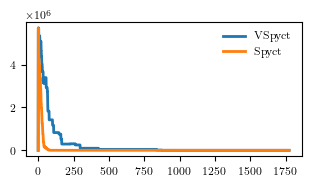

In [45]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(6/2,3.5/2))
fig.set_constrained_layout(True)

ax.plot(bs_vspyct_arr.mean(axis=0), linewidth=2.0, label='VSpyct')
ax.plot(bs_spyct_arr.mean(axis=0), linewidth=2.0, label='Spyct')
# ax.set_xlim(0, 300)

ax.legend(frameon=False)

plt.savefig('../reports/figures/bs_r_heart.pdf')

In [ ]:
# cancer, diabetic, retinopayhy, pbc, cgd (kolonata time presmetaj ja kako tstart - tstop)